<a href="https://colab.research.google.com/github/chuu-shin/CS485-Course-Work-2/blob/main/CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
from google.colab import drive
import logging
import sys
from imutils import paths

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
from torch.backends import cudnn
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import alexnet
from torchvision.models import resnet18
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm
import pickle

In [4]:
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from torchsummary import summary
import matplotlib.pyplot as plt
from imutils import paths
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

import time
import copy

In [5]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML4CV_CW2')

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
101_ObjectCategories  CW2.ipynb  test_data.pkl	train_data.pkl	val_data.pkl


In [6]:
'''image_paths = list(paths.list_images('101_ObjectCategories'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    data.append(img)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)'''

"image_paths = list(paths.list_images('101_ObjectCategories'))\n\ndata = []\nlabels = []\nfor img_path in tqdm(image_paths):\n    label = img_path.split(os.path.sep)[-2]\n\n    img = cv2.imread(img_path)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    img = cv2.resize(img, (224, 224))\n\n    data.append(img)\n    labels.append(label)\n\ndata = np.array(data)\nlabels = np.array(labels)"

In [7]:
'''lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")
lb.classes_'''

'lb = LabelEncoder()\nlabels = lb.fit_transform(labels)\nprint(f"Total Number of Classes: {len(lb.classes_)}")\nlb.classes_'

In [8]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()])

In [ ]:
# data split
'''X_train, X, y_train, y = train_test_split(data, labels,
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X, y,
                                                test_size=0.5,
                                                random_state=42)'''

'X_train, X, y_train, y = train_test_split(data, labels,\n                                          test_size=0.2,\n                                          stratify=labels,\n                                          random_state=42)\nX_val, X_test, y_val, y_test = train_test_split(X, y,\n                                                test_size=0.5,\n                                                random_state=42)'

In [10]:
class MyDataset(Dataset):
    def __init__(self, images, labels= None, transforms = None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = self.X[index][:]

        if self.transforms:
            data = self.transforms(data)

        if self.y is not None:
            return (data, self.y[index])
        else:
            return data

In [11]:
'''train_data = MyDataset(X_train, y_train, train_transforms)
val_data = MyDataset(X_val, y_val, val_transform)
test_data = MyDataset(X_test, y_test, val_transform)

with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)

with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)'''

"train_data = MyDataset(X_train, y_train, train_transforms)\nval_data = MyDataset(X_val, y_val, val_transform)\ntest_data = MyDataset(X_test, y_test, val_transform)\n\nwith open('train_data.pkl', 'wb') as f:\n    pickle.dump(train_data, f)\n\nwith open('val_data.pkl', 'wb') as f:\n    pickle.dump(val_data, f)\n\nwith open('test_data.pkl', 'wb') as f:\n    pickle.dump(test_data, f)"

In [12]:
# Load the datasets from pickle files
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

batch_size = 16

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

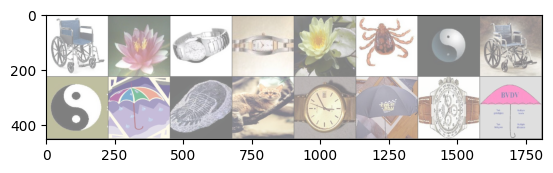

In [13]:
def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return

x, y = next(iter(DataLoader(train_dataloader.dataset, batch_size=16, shuffle=True)))
out = torchvision.utils.make_grid(x)
imgshow(out)

In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'device = {device}')

device = cpu


In [15]:
class EarlyStopping:
    def __init__(self, tolerance=2, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [16]:
def fit(model, dataloader, optimizer, l2_lambda=0.001, l1_lambda=0.0):

    print('-' * 5, 'Training', '-' * 5)

    # Set model to training mode
    model.train()
    # Variables to track training procees (loss and accuracy)
    running_loss = 0.0
    running_correct = 0

    # Iterate over data
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(data)

        # Tracking history
        loss = criterion(outputs, target)

        # Add L2 regularization
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, 2)
        loss += l2_lambda * l2_reg

        # Add L1 regularization
        l1_reg = 0.0
        for param in model.parameters():
            l1_reg += torch.norm(param, 1)  # Calculate L1 norm of parameters
        loss += l1_lambda * l1_reg         # Add L1 regularization term to loss


        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += torch.sum(preds == target.data).item()

        # Compute gradients
        loss.backward()
        # Adjust learning weights
        optimizer.step()

    # Gather performance report
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)

    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")

    return loss, accuracy

In [17]:
def validate(model, dataloader, l2_lambda=0.001, l1_lambda=0.0):

    print('-' * 5, 'Validating', '-' * 5)

    # Set model to evaluate mode
    model.eval()
    # Variables to track validation procees (loss and accuracy)
    running_loss = 0.0
    running_correct = 0

    # Do not update the gradients while evaluating model
    with torch.no_grad():
        # Iterate over data
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            # Make predictions for this batch
            outputs = model(data)

            # Tracking history
            loss = criterion(outputs, target)

            # Add L2 regularization (weight decay) - for loss calculation only
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

            # Add L1 regularization - for loss calculation only
            l1_reg = 0.0
            for param in model.parameters():
                l1_reg += torch.norm(param, 1)
            loss += l1_lambda * l1_reg

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += torch.sum(preds == target.data).item()

        # Gather performance report
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Validation Loss: {loss:.4f}, Val Acc: {accuracy:.4f}')

        return loss, accuracy

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5,
                l2_lambda=0.001, l1_lambda=0.0, lr_scheduler=None):

    # Data structures for saving Loss and Accuracy history
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []

    # Best model saving
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Early Stopping to avoid overfitting
    early_stopping = EarlyStopping(tolerance=2, min_delta=0.2)

    start = time.time()
    # Iterate through epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Perform train and validation processes
        train_epoch_loss, train_epoch_accuracy = fit(model, dataloaders['train'], optimizer, l2_lambda, l1_lambda)
        val_epoch_loss, val_epoch_accuracy = validate(model, dataloaders['val'], l2_lambda, l1_lambda)

        # Track history for both processes
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        if lr_scheduler is not None:
            lr_scheduler.step(val_epoch_loss)
            print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Determine and update best model
        if val_epoch_accuracy > best_acc:
                best_acc = val_epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best accuracy: {best_acc}. The best model was updated.')

        # Use early stopping to prevent overfitting
        early_stopping(train_epoch_loss, val_epoch_loss)
        if early_stopping.early_stop:
          print("Stopped at epoch:", epoch)
          break

    end = time.time()
    print(f'Training complete in {(end-start)/60} minutes')

    print(f'Best Validation Accuracy: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }

    return model, history

In [19]:
class CNN(nn.Module):
    def __init__(self, n_layers, normalization='batch', skip=False, dropout_rate=0.0, l1_lambda=0.0, l2_lambda=0.0):
        super(CNN, self).__init__()
        self.n_layers = n_layers
        self.normalization = normalization # 'batch', 'layer', 'group', 'instance'
        self.skip = skip
        self.dropout_rate = dropout_rate
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.norm1 = self.get_norm_layer(16)  # Get the appropriate normalization layer
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Additional convolutional layers based on n_layers
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()  # Store normalization layers
        self.relus = nn.ModuleList()
        self.pools = nn.ModuleList()

        in_channels = 16
        out_channels = 32
        for _ in range(n_layers - 1):
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.norms.append(self.get_norm_layer(out_channels))  # Get normalization layer
            self.relus.append(nn.ReLU())
            self.pools.append(nn.MaxPool2d(kernel_size=2))

            in_channels = out_channels
            out_channels *= 2

        # Calculate the final output size
        final_out_channels = 16 * (2**(n_layers -1))
        final_out_size = 224 // (2**n_layers)

        # Fully connected layer
        self.fc = nn.Linear(in_features=final_out_channels * final_out_size * final_out_size, out_features=10)

    def get_norm_layer(self, num_features):
        """Returns the appropriate normalization layer based on self.normalization."""
        if self.normalization == 'batch':
            return nn.BatchNorm2d(num_features)
        elif self.normalization == 'layer':
            return nn.LayerNorm(num_features)
        elif self.normalization == 'group':
            return nn.GroupNorm(num_groups=32, num_channels=num_features)
        elif self.normalization == 'instance':
            return nn.InstanceNorm2d(num_features)
        else:
            raise ValueError(f"Invalid normalization type: {self.normalization}")

    def forward(self, x):
        # Pass data through the first convolutional layer
        x = self.conv1(x)
        x = self.norm1(x)  # Apply the selected normalization
        x = self.relu1(x)
        x = self.pool1(x)

        # Store the output of the first layer for skip connection (if enabled)
        identity = x if self.skip else None

        # Pass data through additional convolutional layers
        for i in range(self.n_layers - 1):
            x = self.convs[i](x)
            x = self.norms[i](x)  # Apply the selected normalization
            x = self.relus[i](x)
            if self.dropout_rate > 0: # Apply dropout if dropout_rate is greater than 0
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
            x = self.pools[i](x)

        # Apply skip connection if enabled and dimensions match
        # dimension 안 맞아서 안 됨...
        if self.skip and identity is not None and x.shape == identity.shape:
            x += identity  # Add the identity (output of previous layer)
            identity = x  # Update identity for the next layer


        # Flatten the output
        x = x.view(-1, self.fc.in_features)
        x = self.fc(x)
        return x

In [20]:
model = CNN(n_layers=5)
model.to(device)
# Check model architecture
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [21]:
class MultiClassHingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MultiClassHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target):
        # Convert target to one-hot encoding
        target_onehot = torch.zeros_like(output)
        target_onehot.scatter_(1, target.unsqueeze(1), 1)

        # Calculate hinge loss
        loss = torch.mean(torch.max(torch.zeros_like(output),
                                   self.margin - (output * target_onehot) +
                                   (output * (1 - target_onehot))).sum(dim=1))
        return loss

In [ ]:
initial_lr = 0.001
optimizer = Adam(model.parameters(), lr=initial_lr)

# scheduler = None
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()
# criterion = MultiClassHingeLoss(margin=1.0)

model, history_model = train_model(model=model,
                                dataloaders={'train':train_dataloader, 'val':val_dataloader},
                                criterion=criterion,
                                optimizer=optimizer,
                                num_epochs=15,
                                lr_scheduler=scheduler)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
----------
----- Training -----


38it [00:42,  1.12s/it]


Train Loss: 0.2435, Train Acc: 39.47
----- Validating -----


5it [00:01,  2.66it/s]


Validation Loss: 0.1524, Val Acc: 32.0000
Current Learning Rate: 0.001000
New best accuracy: 32.0. The best model was updated.
Epoch 2/15
----------
----- Training -----


38it [00:43,  1.14s/it]


Train Loss: 0.0865, Train Acc: 67.50
----- Validating -----


5it [00:01,  2.67it/s]


Validation Loss: 0.1110, Val Acc: 70.6667
Current Learning Rate: 0.001000
New best accuracy: 70.66666666666667. The best model was updated.
Epoch 3/15
----------
----- Training -----


38it [00:43,  1.15s/it]


Train Loss: 0.0527, Train Acc: 78.28
----- Validating -----


5it [00:01,  2.63it/s]


Validation Loss: 0.1013, Val Acc: 61.3333
Current Learning Rate: 0.001000
Epoch 4/15
----------
----- Training -----


38it [00:43,  1.15s/it]


Train Loss: 0.0344, Train Acc: 83.91
----- Validating -----


5it [00:01,  2.66it/s]


Validation Loss: 0.1019, Val Acc: 73.3333
Current Learning Rate: 0.001000
New best accuracy: 73.33333333333333. The best model was updated.
Epoch 5/15
----------
----- Training -----


38it [00:43,  1.14s/it]


Train Loss: 0.0327, Train Acc: 86.57
----- Validating -----


5it [00:01,  2.61it/s]


Validation Loss: 0.0785, Val Acc: 73.3333
Current Learning Rate: 0.001000
Epoch 6/15
----------
----- Training -----


38it [00:43,  1.13s/it]


Train Loss: 0.0250, Train Acc: 89.88
----- Validating -----


5it [00:01,  2.63it/s]


Validation Loss: 0.0799, Val Acc: 78.6667
Current Learning Rate: 0.001000
New best accuracy: 78.66666666666667. The best model was updated.
Epoch 7/15
----------
----- Training -----


38it [00:44,  1.17s/it]


Train Loss: 0.0168, Train Acc: 94.86
----- Validating -----


5it [00:02,  1.97it/s]


Validation Loss: 0.0734, Val Acc: 85.3333
Current Learning Rate: 0.001000
New best accuracy: 85.33333333333333. The best model was updated.
Epoch 8/15
----------
----- Training -----


38it [00:43,  1.15s/it]


Train Loss: 0.0117, Train Acc: 96.52
----- Validating -----


5it [00:02,  1.81it/s]


Validation Loss: 0.0661, Val Acc: 85.3333
Current Learning Rate: 0.001000
Epoch 9/15
----------
----- Training -----


  3%|▎         | 1/37 [00:01<00:41,  1.15s/it]